In [ ]:
!pip install yfinance
!pip install ta
!pip install backtesting
!pip install pandas-ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=6b52447fbf888de176cb297d1b3bc076e1169d25f6edb82efa5fedcdf83ae4fc
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173804 sha256=f5d433a8c5ab3e11497b2b662de6631088a00b574d3a1bf1f9da685effec1d1c
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=95f7fd73cd1bea38c028963f6504ab5b8aa69439639137ec8

In [ ]:
import datetime
import pandas_ta as ta
import seaborn as sns
import ta
import numpy as np
import pandas as pd
import yfinance
from backtesting import Backtest
from backtesting import Strategy
from backtesting.lib import crossover

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [ ]:
name = 'ZENSARTECH.NS'
ticker = yfinance.Ticker(name)
df = ticker.history(interval="1d",start="2015-01-01", end="2023-07-01")
df2 = df.copy()
df['Date'] = pd.to_datetime(df.index)
df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

In [ ]:
data = df.copy()
data = data[data.Open != data.Close]
data['Heiken_Close'] = (data.Open+data.Close+data.High+data.Low)/4
data['Heiken_Open'] = data['Open']
for i in range(1, len(data)):
    data['Heiken_Open'][i] = (data.Heiken_Open[i-1]+data.Heiken_Close[i-1])/2

data['Heiken_High'] = data[['High', 'Heiken_Open', 'Heiken_Close']].max(axis=1)
data['Heiken_Low'] = data[['Low', 'Heiken_Open', 'Heiken_Close']].min(axis=1)
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

<ipython-input-4-906f77435105>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Heiken_Open'][i] = (data.Heiken_Open[i-1]+data.Heiken_Close[i-1])/2


In [ ]:
### Optimizing fuction

def optim_func(series):
    if series['# Trades'] < 10:
        return -1
    else:
        return series['Equity Final [$]']/series['Exposure Time [%]']

In [ ]:
data['color'] = 0
for i in range(len(data)):
  if data['Heiken_Close'][i] > data['Heiken_Open'][i]:
    data['color'][i] = 'Green'
  else :
    data['color'][i] = 'Red'
data["SMA20"] = ta.trend.SMAIndicator(data.Heiken_Close, 20).sma_indicator()
data["SMA200"] = ta.trend.SMAIndicator(data.Heiken_Close, 200).sma_indicator()
data["BB_Upper"] =  ta.volatility.BollingerBands(data.Heiken_Close,20,2).bollinger_hband()
data["BB_Lpper"] =  ta.volatility.BollingerBands(data.Heiken_Close, 20,2).bollinger_lband()
data['Band_diff'] = ta.volatility.BollingerBands(data.Heiken_Close, 20,2).bollinger_wband()
data['ATR'] = ta.volatility.AverageTrueRange(data.Heiken_High,data.Heiken_Low,data.Heiken_Close, 14).average_true_range()

<ipython-input-6-2d0192a0d8bb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'][i] = 'Green'


In [ ]:
data_new = data.iloc[1000:, :]
data_new.reset_index(drop=True, inplace=True)
data_new['Buy'] = 0
data_new['Sell'] = 0

<ipython-input-7-09f813aa068e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['Buy'] = 0
<ipython-input-7-09f813aa068e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['Sell'] = 0


In [ ]:
in_position = 0
buyed_index= 0
Buy_signal_index = []
Sell_signal_index=[]
for i in range(len(data_new)-10):
  if in_position == 0:
    if i > buyed_index :
      if data_new['Band_diff'][i] < float(data_new['Band_diff'].describe()['50%']):
        for j in range(0,11):
          if data_new['Heiken_High'][i+j] > data_new['BB_Upper'][i+j] and data_new['Heiken_Close'][i+j] > data_new['SMA200'][i+j] and data_new['Heiken_Close'][i+j] > data_new['SMA20'][i+j]:
            in_position = 1
            buyed_index = i+j
            Buy_signal_index.append(buyed_index)
          break
  if in_position==1:
    if data_new['color'][i] == 'Red' and data_new['color'][i-1] == 'Red' and data_new['Heiken_High'][i-1] < data_new['BB_Upper'][i-1] and data_new['Heiken_Low'][i-1] > data_new['Heiken_Low'][i]:
      in_position = 0
      Sell_signal_index.append(i)

In [ ]:
for i,j in zip(Buy_signal_index, Sell_signal_index):
  data_new.at[i, 'Buy'] = 1
  data_new.at[j, 'Sell'] = 1

In [ ]:
data_new['Buy']

In [ ]:
data_new.drop(['Open', 'High', 'Low', 'Close','color'], axis=1, inplace=True)
desired_order = ['Date', 'Heiken_Open', 'Heiken_High', 'Heiken_Low', 'Heiken_Close',
                 'SMA20', 'SMA200', 'BB_Upper', 'BB_Lpper', 'Band_diff', 'ATR','Buy', 'Sell']

data_new = data_new[desired_order]
data_new.columns = ['Date','Open', 'High', 'Low', 'Close',
       'SMA20', 'SMA200', 'BB_Upper', 'BB_Lpper', 'Band_diff','ATR', 'Buy', 'Sell']

<ipython-input-10-307abe289a56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new.drop(['Open', 'High', 'Low', 'Close','color'], axis=1, inplace=True)


In [ ]:
data_new.set_index('Date', inplace=True)

In [ ]:
def SIGNAL_BUY():
    return data_new.Buy
def SIGNAL_SELL():
    return data_new.Sell

In [ ]:
class Suspension_and_expension(Strategy):

    # Do as much initial computation as possible
    def init(self):
      super().init()
      self.signal_buy = self.I(SIGNAL_BUY)
      self.signal_sell = self.I(SIGNAL_SELL)
    # Step through bars one by one
    # Note that multiple buys are a thing here
    def next(self):
        super().next()
        if self.signal_buy == 1:
          #  sl1 = self.data.Low[-1] - 0.02*(self.data.Low[-1])
            self.buy()
        elif self.signal_sell[-1] ==1:
            self.position.close()

bt = Backtest(data_new, Suspension_and_expension, cash=10_000, commission=0.001026)
stat = bt.run()
stat


# #ATR distance Trailing SL

# class MyCandlesStrat(Strategy):
#     sltr = 2
#     def init(self):
#         super().init()
#         self.signal_buy = self.I(SIGNAL_BUY)

#     def next(self):
#         super().next()
#         sltr = self.sltr
#         for trade in self.trades:
#           trade.sl = max(trade.sl or -np.inf, self.data.Close[-1] - sltr)

#         if self.signal_buy == 1 and len(self.trades)==0: # trades number change!
#             sl1 = self.data.Close[-1] - sltr
#             self.buy(sl=sl1)

# bt = Backtest(data_new, MyCandlesStrat, cash=10_000, commission=.000)
# stat = bt.run()
# stat

Start                     2019-01-25 00:00...
End                       2023-06-30 00:00...
Duration                   1617 days 00:00:00
Exposure Time [%]                   18.807339
Equity Final [$]                 40616.794728
Equity Peak [$]                  41395.379754
Return [%]                         306.167947
Buy & Hold Return [%]               86.455135
Return (Ann.) [%]                     38.2701
Volatility (Ann.) [%]                25.92889
Sharpe Ratio                         1.475964
Sortino Ratio                        4.105824
Calmar Ratio                         2.258091
Max. Drawdown [%]                  -16.947987
Avg. Drawdown [%]                   -4.073306
Max. Drawdown Duration      596 days 00:00:00
Avg. Drawdown Duration       64 days 00:00:00
# Trades                                   18
Win Rate [%]                        77.777778
Best Trade [%]                      41.709125
Worst Trade [%]                     -6.125212
Avg. Trade [%]                    

In [ ]:
stat['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,45,62,70,221.761870,222.387074,28.134181,0.002819,2019-05-03 00:00:00+05:30,2019-05-15 00:00:00+05:30,12 days
1,43,83,93,228.839437,235.124088,270.240009,0.027463,2019-06-03 00:00:00+05:30,2019-06-18 00:00:00+05:30,15 days
2,43,98,104,235.148968,236.505140,58.315382,0.005767,2019-06-25 00:00:00+05:30,2019-07-03 00:00:00+05:30,8 days
3,61,399,410,167.416156,188.188140,1267.091018,0.124074,2020-09-15 00:00:00+05:30,2020-09-30 00:00:00+05:30,15 days
4,63,442,456,183.544293,211.951733,1789.668729,0.154772,2020-11-14 00:00:00+05:30,2020-12-07 00:00:00+05:30,23 days
5,58,490,495,230.323731,225.770439,-264.090958,-0.019769,2021-01-25 00:00:00+05:30,2021-02-02 00:00:00+05:30,8 days
6,58,507,521,223.970850,275.544974,2991.299212,0.230272,2021-02-18 00:00:00+05:30,2021-03-10 00:00:00+05:30,20 days
7,61,559,561,262.687480,260.501326,-133.355431,-0.008322,2021-05-10 00:00:00+05:30,2021-05-12 00:00:00+05:30,2 days
8,61,562,569,260.691544,269.553634,540.587503,0.033995,2021-05-14 00:00:00+05:30,2021-05-25 00:00:00+05:30,11 days
9,61,570,574,270.884079,280.065003,560.036323,0.033892,2021-05-26 00:00:00+05:30,2021-06-01 00:00:00+05:30,6 days


In [ ]:
stat['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
Date,,,
2019-01-25 00:00:00+05:30,10000.000000,0.000000,NaT
2019-01-28 00:00:00+05:30,10000.000000,0.000000,NaT
2019-01-29 00:00:00+05:30,10000.000000,0.000000,NaT
2019-01-30 00:00:00+05:30,10000.000000,0.000000,NaT
2019-01-31 00:00:00+05:30,10000.000000,0.000000,NaT
...,...,...,...
2023-06-22 00:00:00+05:30,41394.478256,0.018813,NaT
2023-06-23 00:00:00+05:30,41394.478256,0.018813,NaT
2023-06-26 00:00:00+05:30,41394.478256,0.018813,NaT


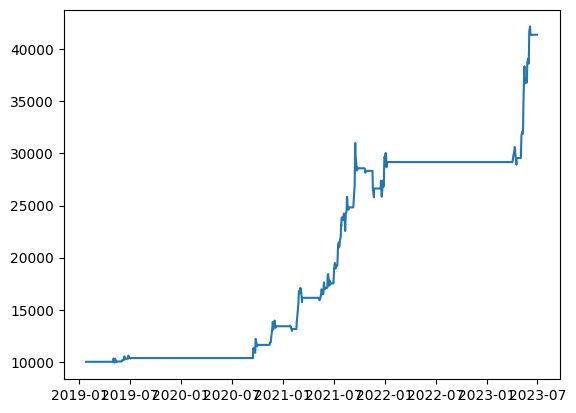

In [ ]:
import matplotlib.pyplot as plt
plt.plot(stat['_equity_curve']['Equity'])

In [ ]:
stat['_strategy']

<Strategy Suspension_and_expension>

## Need to try :-


* Take stop loss at 2% and if profit is above 4% then use the sell condition.
* Exit when red candlw is not touching Upper band
* Take less next forward days, replace 11 with 6
* Check if buying and selling is occuring on correct candle.

